### 텐서
- 지금까지 구현한 DeZero 함수들이 텐서와도 다를 수 있음을 보여줍니다.

- 주의할 점 파악과 동시에 DeZero의 확장

- 벡터나 행렬 등에 텐서를 주로 사용함

### DeZero 구현 함수
- input & output은 모두 scalar 가정

- x는 단일 값인 scalar -> 0차원의 ndarray instance

In [ ]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sin(x)
print(y)

In [ ]:
x = Variable(np.array([[1,2,3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

### 역전파 구현
- scalar 대상 -> 역전파 구현

- 텐서 사용 -> 역전파 구현 가능 ? -> 가능함

* sum 함수 이용하여 원소의 총합을 구해 하나의 scalar로 출력됨

In [ ]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(x)
print(y)

In [ ]:
x = np.array([[1,2,3], [4,5,6]])
y = np.reshape(x, (6,))
print(y)

### Reshape 역전파
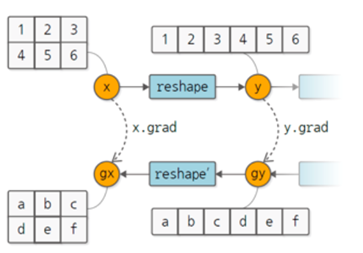

- 형상 구현으로 계산 구현 X

- 출력 쪽에서 전해지는 기울기를 그대로 입력으로 흘림

- 기울기의 형상이 입력과 같아지게 변환하는 구조

- 역전파의 구조이기에 출력 -> 기울기 전달

- (6,)인 형상을 (2,3)으로 반환함

In [ ]:
class Reshpae(Function):
  def __init__(self. shape):
    self.shape = shape
  def forward(self, x):
    self.x_shape = x.shape
    y = x.reshape(self.shape)
    return y
  def backward(self, gy):
    return reshape(gy. self.x_shape)

In [ ]:
from dezero.core import as_variable

def reshape(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return Reshape(shape)(x)

### reshape 사용

In [ ]:
class Variable:
  ....
  def reshape(self, *shape):
    if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
      shape = shape[0]
    return dezero.functions.reshape(self, shape)

In [ ]:
x = Variable(np.random.randh(1,2,3))
y = x.reshape((2,3))
y = x.reshape(2,3)

### Transpose 구현

In [ ]:
class Transpose(Function):
  def forward(self, x):
    y = np.transpose(x)
    return y

  def backward(self, gy):
    gx = transpose(gy)
    return gx

def transpose(x):
  return transpose()(x)

- 순전파의 경우 np.transpose 사용

- 역전파의 경우 출력의 기울기를 transpose 사용하여 변환

In [ ]:
class Variable:
  ....
  def transpose(self):
    return dezero.functions.transpose(self)

  @property
  def T(self):
    return dezero.functions.transpose(self)

In [ ]:
x = Variable(np.random.randh(1,2,3))
y = x.transpose()
y = x.T

### Numpy -> np.transpose 범용적 사용
- 축의 순서 지정에 따라 데이터의 축이 변경됨

- None 인수의 경우 축이 역순으로 정렬됨

- x 행렬 -> x.transpose() 실행 -> 행렬 전치
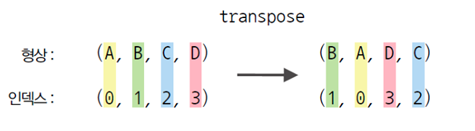

### 덧셈의 미분 구조
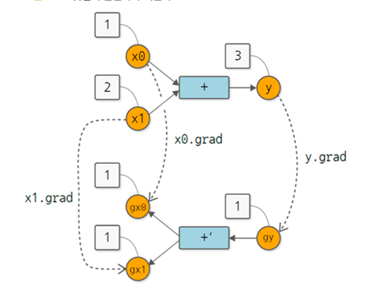

In [ ]:
class Sum(Function):
  def forward(self, x):
    self.x_shape = x.shape
    y = x.sum()
    return y

  def backward(self, gy):
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum(x):
  return Sum()(x)

#순전파 : sum -> 진행
#역전파 : broadcast -> 진행

In [ ]:
from dezero.utils import sum_to

x = np.array([[1,2,3], [4,5,6]])
y = sum_to(x, (1,3))
print(y)

y = sum_to(x, (2,1))
print(y)

#sum_to함수는 shape와 같은 형상이 되게 만들어줌
#기능은 np.sum과 같음 / 하지만 인수를 주는 방식이 다름

In [ ]:
class BroadcastTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    xp = dezero.cuda.get_array_module(x)
    y = xp.broadcast_to(x, self.shape)
    return y

  def backward(self, gy):
    gx = sum_to(gy, self.x_shape)
    return gx

def broadcast_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return BroadcastTo(shape)(x)

In [ ]:
class SumTo(Function):
  def __init__(self, shape):
    self.shape = shape

  def forward(self, x):
    self.x_shape = x.shape
    y = utils.sum_to(x, self.shape)
    return y

  def backward(self, gy):
    gx = broadcast_to(gy, self.x_shape)
    return gx

def sum_to(x, shape):
  if x.shape == shape:
    return as_variable(x)
  return SumTo(shape)(x)

- 역전파 : 입력 x와 형상을 같게 만들고 기울기의 원소 복제하는 구조

- broadcast_to = sum_to (상호 의존적 관계 형성)

In [ ]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    gx0, gx1 = gy, gy
    if self.x0_shape != self.x1_shape:
      gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
      gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
    return gx0, gx1

#shape => 자기 형상 기억

### 행렬 곱 연산
- 순전파 : np.dot -> (대신) x.dot 구현

- Dezero의 transpose 호출

- X.grad.shape = x.shape / w.grad.shape = W.shape
서로가 동일함을 알 수 있음

In [ ]:
class MatMul(Function):
  def forward(self, x, W):
    y = x.dot(W)
    return y

  def backward(self, gy):
    x, W = self.inputs
    gx = gy.dot(W.T)
    gW = x.T.dot(gy)
    return gx, gW

def matmul(x, W):
  return MatMul()(x, W)